In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import pandas as pd
from pandas import Series
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

RANDOM_SEED = 42

#PATH = '/kaggle/input/sf-dst-scoring/'
PATH = './data/'

In [8]:
train = pd.read_csv(PATH+'train.csv')
test = pd.read_csv(PATH+'test.csv')
sample_submission = pd.read_csv(PATH+'sample_submission.csv')

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту


In [9]:
def dataset_info(df):
    print('Размерность датасета: ', df.shape)
    display(df.head(5))
    df.info()

In [10]:
dataset_info(train)

Размерность датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [11]:
dataset_info(test)

Размерность датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [12]:
train['Train'] = 1  # помечаем где у нас трейн
test['Train'] = 0  # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True)

из информации видим разницу в количестве признаков. в тестовых данных отсутствует параметр default, что логично.

Названия параметров стандартизированы переименовывать ничего не буду.

данные загружены корректно

# 2.Предварительный анализ
Изучим предоставленные данные подробнее.

Преобразования, осуществляемые с тренировочными данными будем сразу применять к тестовым.

Генерация новых признаков будет осуществляться после .

In [13]:
df.isnull().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

имеются пропуски только в графе education, пропуски заполнять будем на месте.

## 2.1 client_id

In [14]:
df.client_id

0          25905
1          63161
2          25887
3          16222
4         101655
           ...  
110143     83775
110144    106254
110145     81852
110146      1971
110147     69044
Name: client_id, Length: 110148, dtype: int64

### Вывод 2.2 client_id
Пропусков нет. признак визуально изучен

## 2.2 app_date
 дата подачи заявки

In [15]:
df.app_date

0         01FEB2014
1         12MAR2014
2         01FEB2014
3         23JAN2014
4         18APR2014
            ...    
110143    31MAR2014
110144    25APR2014
110145    30MAR2014
110146    07JAN2014
110147    17MAR2014
Name: app_date, Length: 110148, dtype: object

визуальный осмотр показал как храниться дата подачи заявки.
Необходимо из типа object перевести в формат datetime.
используем встроенный метод pandas

In [16]:
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
print(df.app_date.head(5))

0   2014-02-01
1   2014-03-12
2   2014-02-01
3   2014-01-23
4   2014-04-18
Name: app_date, dtype: datetime64[ns]


Проверим корректность переформатирования данных.
Количество пропусков, количество получившихся месяцев, количество получившихся годов, количество получившихся дней.

In [17]:
print('количество пропусков \n\r', df.app_date.isnull().sum())
print('список годов \n\r', df.app_date.dt.year.value_counts())
print('список месяцев \n\r', df.app_date.dt.month.value_counts())
print('список дней \n\r', df.app_date.dt.day.value_counts())

количество пропусков 
 0
список годов 
 2014    110148
Name: app_date, dtype: int64
список месяцев 
 3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64
список дней 
 17    4454
28    4338
18    4321
21    4230
11    4037
24    4035
14    3985
27    3924
15    3916
10    3836
4     3830
3     3818
20    3807
19    3737
22    3704
7     3642
5     3587
12    3559
25    3533
13    3471
16    3444
6     3412
9     3214
26    3141
1     2937
23    2899
30    2774
8     2747
2     2730
29    2553
31    2533
Name: app_date, dtype: int64


### Вывод 2.2 app_date
Дата подачи заявки переформатирована из типа object в тип datetime.
Пропусков нет, форматирование прошло корректно
Заметим что информация о клиентах обратившихся в первые 4 месяца 2014 года.
Потенциально можно выделить новые признаки:
месяц подачи заявка,день недели подачи заявка, день месяца подачи заявка, день от начала года(вдруг и это влияет)

## 2.3 education

In [18]:
def obj_describer(df, param):
    print('доля пропусков: ', round(
        df[param].isnull().sum()/len(df[param]), 4))
    print('Значения параметра и их количество')
    df[param].value_counts().plot.bar()
    print(df[param].value_counts())
    plt.subplots(figsize=(12, 4))
    sns.barplot(data=df, x=df[param], y='default')
    plt.show()

доля пропусков:  0.0042
Значения параметра и их количество
SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64


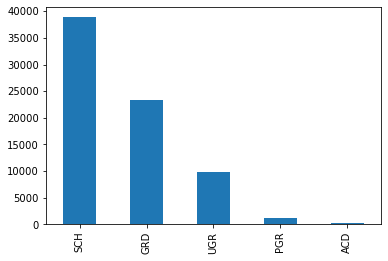

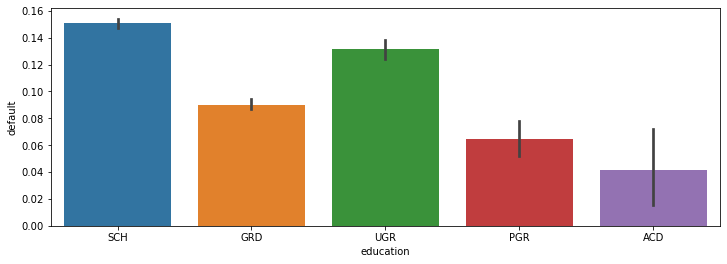

In [19]:
obj_describer(df[df['Train'] == 1], 'education')

Доля пропусков в параметре составляет 0.4 %
 можно заменить пропуски самым популярным значением.

доля пропусков:  0.0
Значения параметра и их количество
SCH    39167
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64


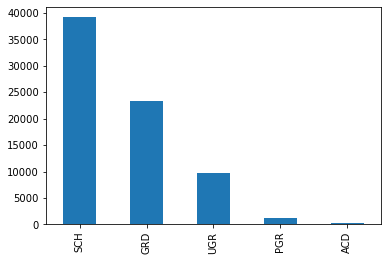

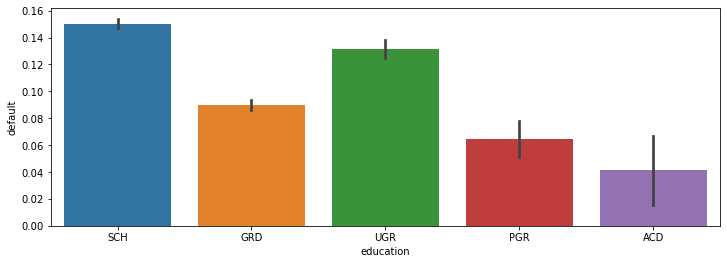

In [20]:
df.education = df.education.fillna('SCH')
obj_describer(df[df['Train'] == 1], 'education')

In [21]:
education_code = {'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}

df['education'] = df['education'].apply(lambda x: education_code[x])

df.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,2014-02-01,1,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,2014-03-12,1,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,2014-02-01,1,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,2014-01-23,1,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,2014-04-18,2,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


### Вывод 2.3 education
Доля пропусков составляла 0.4%, пропуски были заполнены самым популярным значением SCH.
Признак имеет тип object, хоть и хранит строки. Перекодирование признака с помощью labelencoder буду осуществлять позже, лиюл же сгенерирую дамми-признаки

## 2.4 sex

доля пропусков:  0.0
Значения параметра и их количество
F    41562
M    32237
Name: sex, dtype: int64


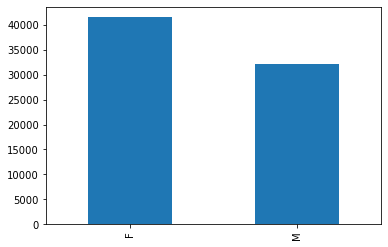

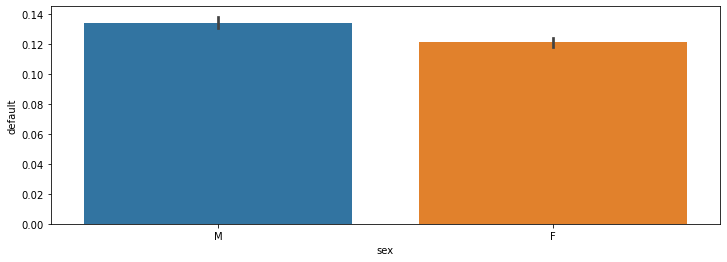

In [22]:
obj_describer(df[df['Train'] == 1], 'sex')

### Вывод 2.4 sex
Пропусков нет.
Выбросов нет.

## 2.5 age

In [23]:
def num_describer(df, param):
    nulls = round(df[param].isnull().sum()/len(df[param]), 4)
    low = df[param].min()
    median = df[param].median()
    mean = df[param].mean()
    std = round(df[param].std(), 4)
    hight = df[param].max()
    IQR = df[param].quantile(
        0.75) - df[param].quantile(0.25)
    perc25 = df[param].quantile(0.25)
    perc75 = df[param].quantile(0.75)
    print('доля пропусков : {} \n\r'.format(nulls),
          'min : {} \n\r'.format(low),
          '25-й перцентиль: {} \n\r'.format(perc25),
          'медиана: {} \n\r'.format(median),
          'среднее: {} \n\r'.format(mean),
          'стандартное отклонение: {} \n\r'.format(std),
          'max : {} \n\r'.format(hight),
          '75-й перцентиль: {} \n\r'.format(perc75),
          "IQR: {} \n\r".format(IQR),
          "Границы выбросов: [{f}, {l}] \n\r".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    fig, (ax1, ax2, ax3) = plt.subplots(
        nrows=1, ncols=3,
        figsize=(10, 5))
    ax1.hist(df[param], label=param)
    ax1.set_title(param)
    ax1.legend()
    ax2.boxplot(df[param])
    ax2.legend()
    ax3.hist(np.log(df[param]+1), label=param)
    ax3.set_title('log_'+param)
    ax3.legend()
    plt.show()

доля пропусков : 0.0 
 min : 21 
 25-й перцентиль: 30.0 
 медиана: 37.0 
 среднее: 39.280640659087524 
 стандартное отклонение: 11.5204 
 max : 72 
 75-й перцентиль: 48.0 
 IQR: 18.0 
 Границы выбросов: [3.0, 75.0] 



No handles with labels found to put in legend.


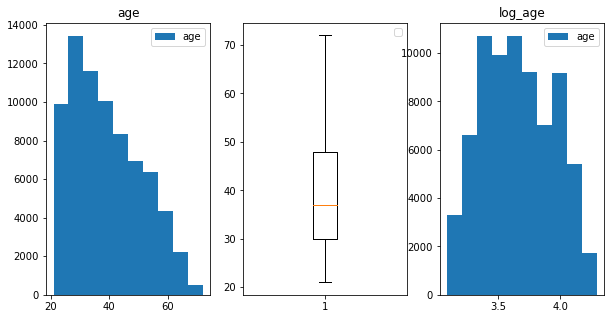

In [24]:
num_describer(df[df['Train'] == 1], 'age')

### Вывод 2.5 age
Пропусков нет.
Выбросов нет(исходя из мин и макс значений и границ выбросов)
Значения распределены логнормально.

## 2.7 car

доля пропусков:  0.0
Значения параметра и их количество
N    49832
Y    23967
Name: car, dtype: int64


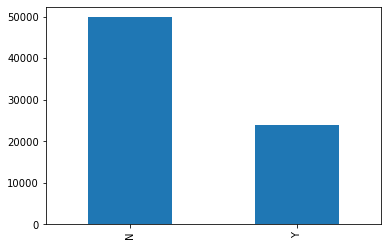

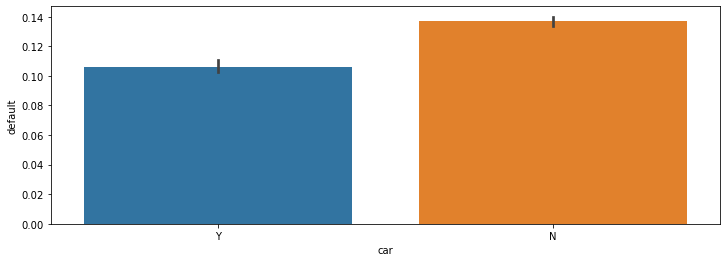

In [25]:
obj_describer(df[df['Train'] == 1], 'car')

### Вывод 2.7 car
Пропусков нет.
Выбросов нет.

## 2.8 car_type

доля пропусков:  0.0
Значения параметра и их количество
N    59791
Y    14008
Name: car_type, dtype: int64


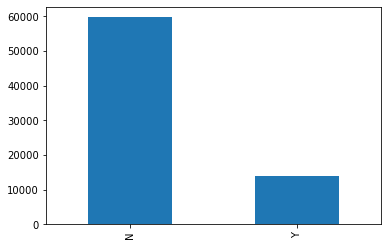

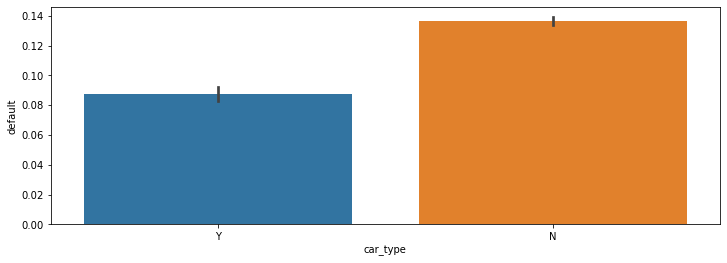

In [26]:
obj_describer(df[df['Train'] == 1], 'car_type')

### Вывод 2.8 car_type
Выбросов нет.
Пропусков нет

## 2.9 decline_app_cnt

доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 0.2757489938888061 
 стандартное отклонение: 0.8043 
 max : 33 
 75-й перцентиль: 0.0 
 IQR: 0.0 
 Границы выбросов: [0.0, 0.0] 



No handles with labels found to put in legend.


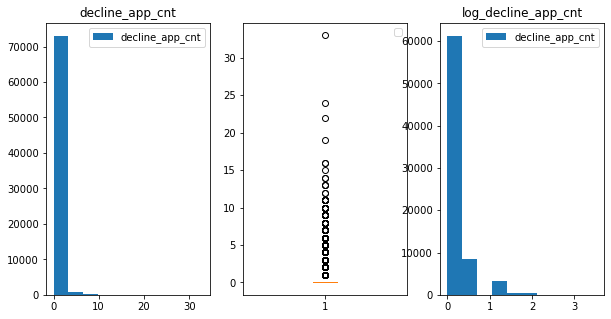

In [27]:
num_describer(df[df['Train'] == 1], 'decline_app_cnt')

In [28]:
def blowout(df, param):
    IQR = df[param].quantile(0.75) - df[param].quantile(0.25)
    perc25 = df[param].quantile(0.25)
    perc75 = df[param].quantile(0.75)
    outs = len(df[(df[param] < perc25-1.5*IQR) | (df[param] > perc75+1.5*IQR)])
    print('Доля выбросов составляет {} \n\r'.format(round(outs/len(df), 4)),
          'Всего выбросов {}'.format(outs))
    temp = pd.DataFrame(np.log(df[param]+1))
    IQR_log = temp[param].quantile(0.75) - temp[param].quantile(0.25)
    perc25_log = temp[param].quantile(0.25)
    perc75_log = temp[param].quantile(0.75)
    outs_log = len(temp[(temp[param] < perc25_log-1.5*IQR_log)
                        | (temp[param] > perc75_log+1.5*IQR_log)])
    print('Доля выбросов после логарифмирования составляет {} \n\r'.format(round(outs_log/len(temp), 4)),
          'Всего выбросов после логарифмирования {}'.format(outs_log))

In [29]:
blowout(df[df['Train'] == 1], 'decline_app_cnt')

Доля выбросов составляет 0.1705 
 Всего выбросов 12585
Доля выбросов после логарифмирования составляет 0.1705 
 Всего выбросов после логарифмирования 12585


### Вывод 2.9 decline_app_cnt
Пропусков нет.
Выбросов много, 17% , даже после логарифмирования. удалять их пока не буду

## 2.10 good_work

доля пропусков:  0.0
Значения параметра и их количество
0    61630
1    12169
Name: good_work, dtype: int64


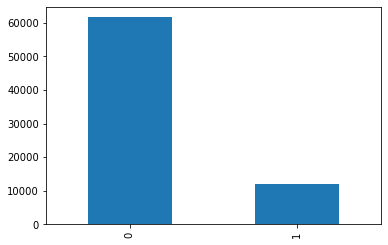

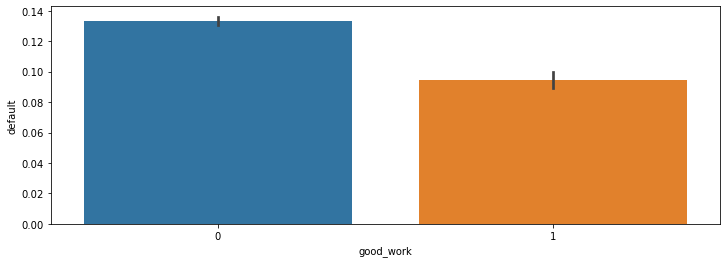

In [30]:
obj_describer(df[df['Train'] == 1], 'good_work')

### Вывод 2.10 good_work
Выбросов нет, пропусков нет

## 2.11 score_bki

доля пропусков : 0.0 
 min : -3.62458632 
 25-й перцентиль: -2.259533835 
 медиана: -1.92082293 
 среднее: -1.9047236272216417 
 стандартное отклонение: 0.4982 
 max : 0.19977285 
 75-й перцентиль: -1.56983126 
 IQR: 0.6897025750000001 
 Границы выбросов: [-3.2940876975, -0.5352773974999998] 



No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


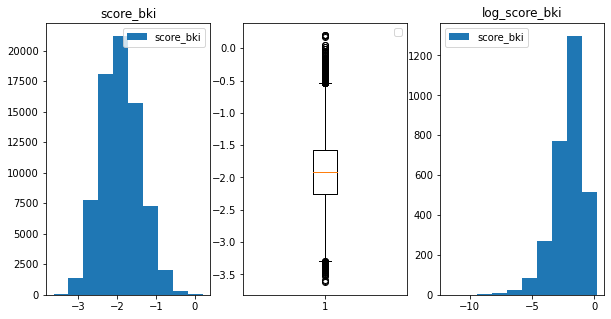

In [31]:
num_describer(df[df['Train'] == 1], 'score_bki')

In [32]:
blowout(df[df['Train'] == 1], 'score_bki')

Доля выбросов составляет 0.0048 
 Всего выбросов 351
Доля выбросов после логарифмирования составляет 0.0012 
 Всего выбросов после логарифмирования 85


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Вывод 2.11 score_bki
Пропусков нет.
Выбросов не много, распределение нормальное.
Логарифмирование позволяет избавиться от выбросов. Надо запомниьть

## 2.12 bki_request_cnt
количество запросов в БКИ

доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 1.0 
 среднее: 2.0003387579777505 
 стандартное отклонение: 2.2521 
 max : 53 
 75-й перцентиль: 3.0 
 IQR: 3.0 
 Границы выбросов: [-4.5, 7.5] 



No handles with labels found to put in legend.


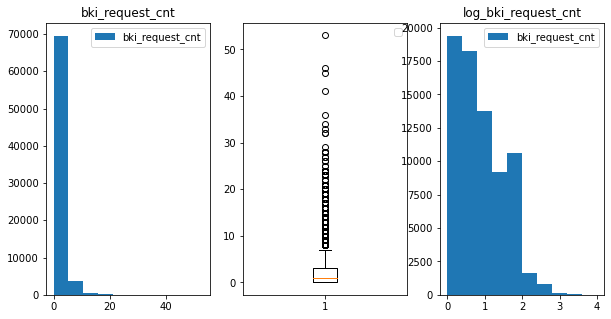

In [33]:
num_describer(df[df['Train'] == 1], 'bki_request_cnt')

In [34]:
blowout(df[df['Train'] == 1], 'bki_request_cnt')

Доля выбросов составляет 0.0238 
 Всего выбросов 1755
Доля выбросов после логарифмирования составляет 0.0001 
 Всего выбросов после логарифмирования 9


### Вывод 2.12 bki_request_cnt
Пропусков нет.
Выбросов немного удалять не стал.
Распределеие кажется логнормальное.

## 2.13 region_rating

доля пропусков : 0.0 
 min : 20 
 25-й перцентиль: 50.0 
 медиана: 50.0 
 среднее: 56.725700890255965 
 стандартное отклонение: 13.0557 
 max : 80 
 75-й перцентиль: 60.0 
 IQR: 10.0 
 Границы выбросов: [35.0, 75.0] 



No handles with labels found to put in legend.


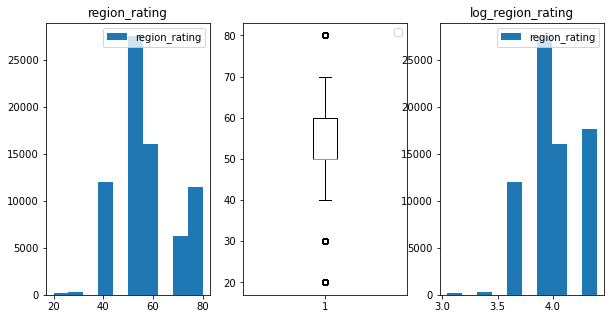

In [35]:
num_describer(df[df['Train'] == 1], 'region_rating')

In [36]:
blowout(train, 'region_rating')

Доля выбросов составляет 0.1623 
 Всего выбросов 11975
Доля выбросов после логарифмирования составляет 0.1623 
 Всего выбросов после логарифмирования 11975


доля пропусков:  0.0
Значения параметра и их количество
50    27523
60    16075
40    12027
80    11469
70     6199
30      300
20      206
Name: region_rating, dtype: int64


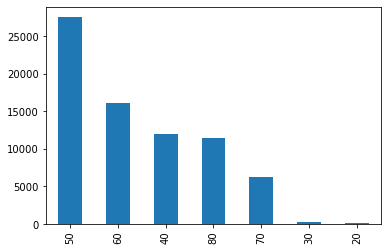

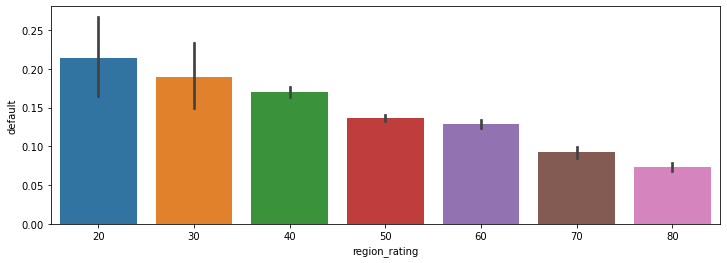

In [37]:
obj_describer(df[df['Train'] == 1], 'region_rating')

### Вывод 2.13 region_rating
распределение нормальное.
Выбросов много - 16%
логарифмирование выбросы не убирает.

## 2.14 home_address

доля пропусков:  0.0
Значения параметра и их количество
2    39956
1    32585
3     1258
Name: home_address, dtype: int64


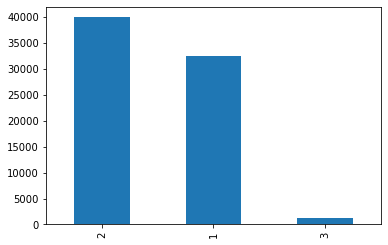

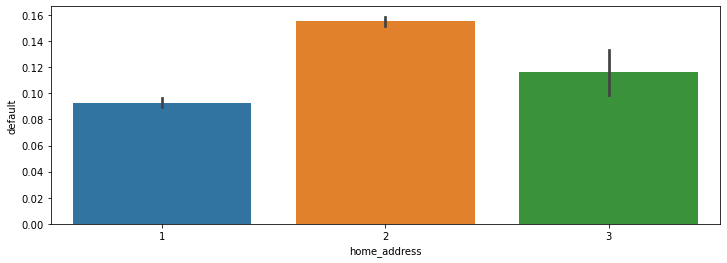

In [38]:
obj_describer(df[df['Train'] == 1], 'home_address')

### Вывод 2.14 home_address
Выбросов нет,пропусков нет.

## 2.15 work_address

доля пропусков:  0.0
Значения параметра и их количество
3    44959
2    20506
1     8334
Name: work_address, dtype: int64


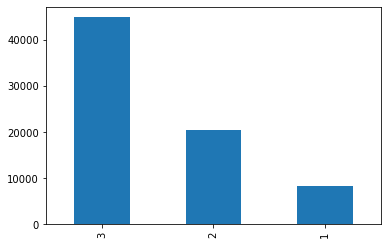

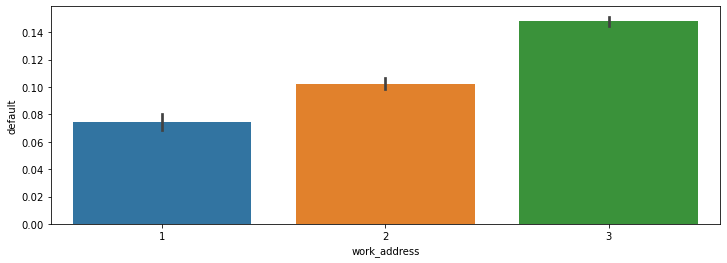

In [39]:
obj_describer(df[df['Train'] == 1], 'work_address')

### вывод 2.15 work_address
Выбросов нет, пропусков нет.
Потенциально можно рассмотреть создание нового признака - address_agreement.
для тех у кого категория адреса работы и дома совпадают

## 2.16 income

доля пропусков : 0.0 
 min : 1000 
 25-й перцентиль: 20000.0 
 медиана: 30000.0 
 среднее: 41099.77541701107 
 стандартное отклонение: 46166.3224 
 max : 1000000 
 75-й перцентиль: 48000.0 
 IQR: 28000.0 
 Границы выбросов: [-22000.0, 90000.0] 



No handles with labels found to put in legend.


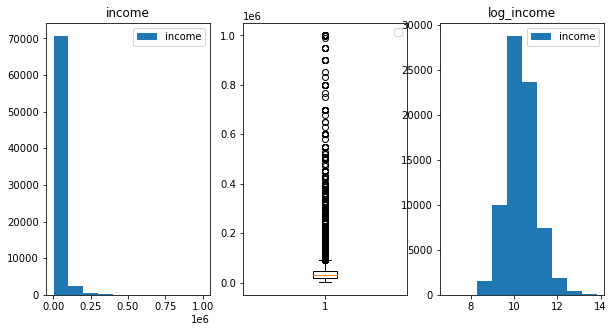

In [40]:
num_describer(df[df['Train'] == 1], 'income')

In [41]:
blowout(df[df['Train'] == 1], 'income')

Доля выбросов составляет 0.0636 
 Всего выбросов 4695
Доля выбросов после логарифмирования составляет 0.0239 
 Всего выбросов после логарифмирования 1767


### вывод 2.16 income
Пропусков нет.Выбросы есть.
распределение логнормальное.
адо рассмотреть возможность логарифмировать данный признак.

## 2.17 sna
связь заемщика с клиентами банка

доля пропусков:  0.0
Значения параметра и их количество
1    47301
4    11749
2    10626
3     4123
Name: sna, dtype: int64


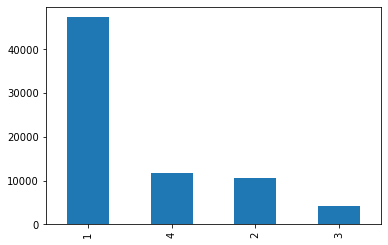

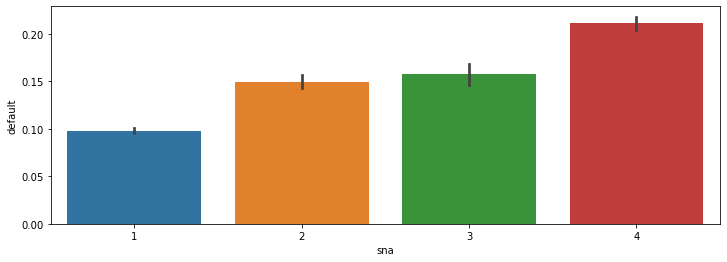

In [42]:
obj_describer(df[df['Train'] == 1], 'sna')

### вывод 2.17 sna
Пропусков нет, выбросов нет.

## 2.18 first_time

доля пропусков : 0.0 
 min : 1 
 25-й перцентиль: 2.0 
 медиана: 3.0 
 среднее: 2.7654575265247496 
 стандартное отклонение: 1.0095 
 max : 4 
 75-й перцентиль: 4.0 
 IQR: 2.0 
 Границы выбросов: [-1.0, 7.0] 



No handles with labels found to put in legend.


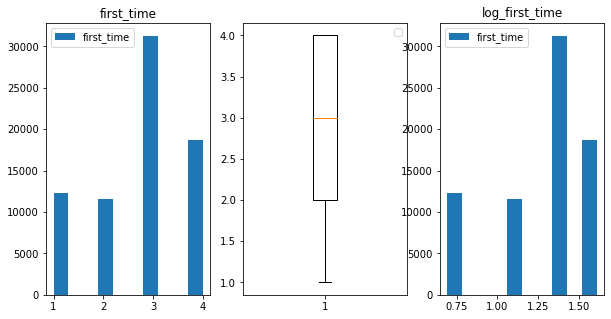

In [43]:
num_describer(df[df['Train'] == 1], 'first_time')

доля пропусков:  0.0
Значения параметра и их количество
3    31255
4    18737
1    12239
2    11568
Name: first_time, dtype: int64


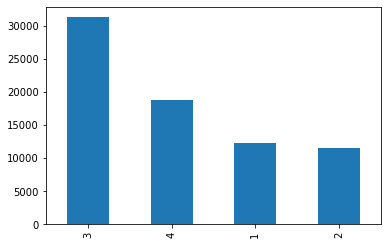

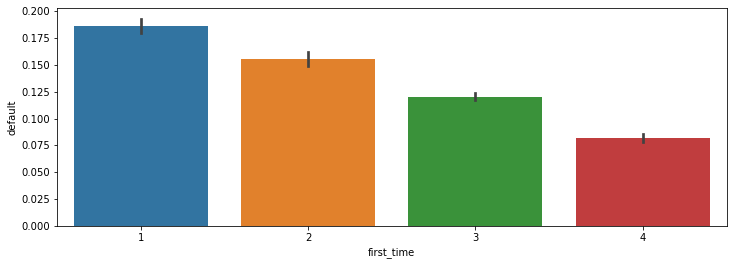

In [44]:
obj_describer(df[df['Train'] == 1], 'first_time')

## вывод 2.18 first_time
Пропусков нет, выбросов нет.
Распределение нормальное.

## 2.19 foreign_passport

доля пропусков:  0.0
Значения параметра и их количество
N    62733
Y    11066
Name: foreign_passport, dtype: int64


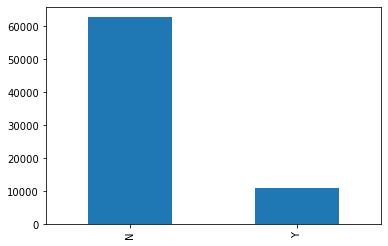

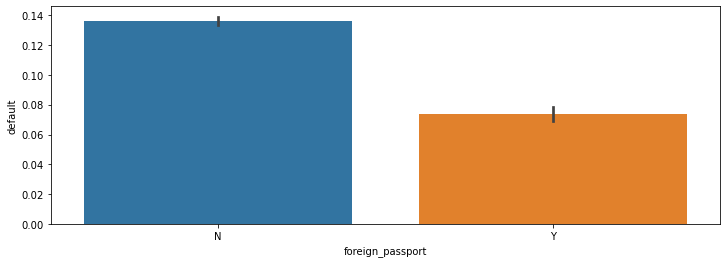

In [45]:
obj_describer(df[df['Train'] == 1], 'foreign_passport')

## вывод 2.19 foreign_passport
Выбросов нет, пропусков нет.

# 3 Генерация новых признаков

## 3.1 Генерация новых признаков из празника app_date

In [46]:
#месяц подачи заявки
df['month'] = df.app_date.apply(lambda x: x.month)
df.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,month
0,25905,2014-02-01,1,M,62,Y,Y,0,0,-2.008753,...,50,1,2,18000,4,1,N,0.0,1,2
1,63161,2014-03-12,1,F,59,N,N,0,0,-1.532276,...,50,2,3,19000,4,1,N,0.0,1,3
2,25887,2014-02-01,1,M,25,Y,N,2,0,-1.408142,...,80,1,2,30000,1,4,Y,0.0,1,2
3,16222,2014-01-23,1,F,53,N,N,0,0,-2.057471,...,50,2,3,10000,1,3,N,0.0,1,1
4,101655,2014-04-18,2,M,48,N,N,0,1,-1.244723,...,60,2,3,30000,1,4,Y,0.0,1,4


доля пропусков:  0.0
Значения параметра и их количество
3    21178
2    18028
4    17683
1    16910
Name: month, dtype: int64


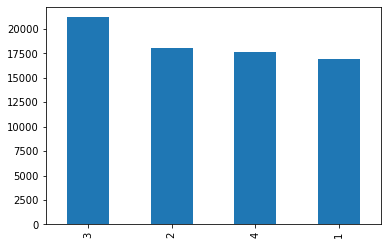

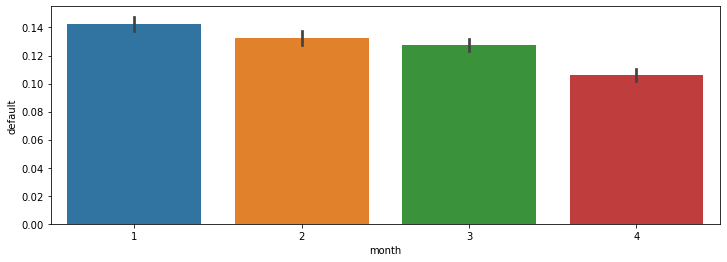

In [47]:
obj_describer(df[df['Train'] == 1], 'month')

Видимо к февралю политика по заемщикам стала строже))

In [48]:
df['weekday'] = df.app_date.apply(lambda x: x.weekday())
df.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,month,weekday
0,25905,2014-02-01,1,M,62,Y,Y,0,0,-2.008753,...,1,2,18000,4,1,N,0.0,1,2,5
1,63161,2014-03-12,1,F,59,N,N,0,0,-1.532276,...,2,3,19000,4,1,N,0.0,1,3,2
2,25887,2014-02-01,1,M,25,Y,N,2,0,-1.408142,...,1,2,30000,1,4,Y,0.0,1,2,5
3,16222,2014-01-23,1,F,53,N,N,0,0,-2.057471,...,2,3,10000,1,3,N,0.0,1,1,3
4,101655,2014-04-18,2,M,48,N,N,0,1,-1.244723,...,2,3,30000,1,4,Y,0.0,1,4,4


доля пропусков:  0.0
Значения параметра и их количество
1    12176
0    12024
2    11740
3    11615
4    11263
5     8231
6     6750
Name: weekday, dtype: int64


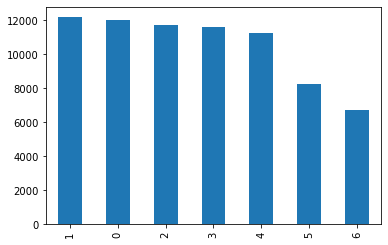

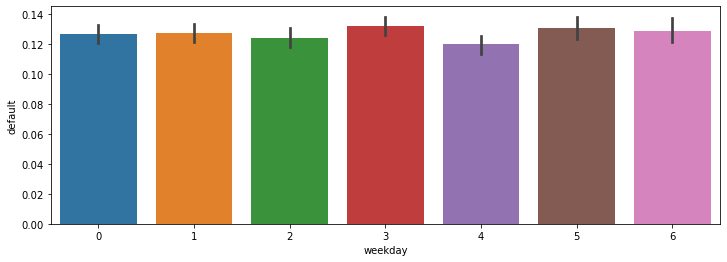

In [49]:
obj_describer(df[df['Train'] == 1], 'weekday')

День недели когда подана заявка не влияет.
З.Ы. Ну а вдруг по понедельникам все плохо с одобряемостью и потому дефолтом меньше, а в пятницу наоборот))
Увидели разницу дефолта по месяцам, вдруг она менялась линейно, добавим показатель как количество дней от 1 января до дня подачи заявки.

In [50]:
first_day = df.app_date.min()
last_day = df.app_date.max()
print(first_day, last_day)

2014-01-01 00:00:00 2014-04-30 00:00:00


In [51]:
df['days'] = (df.app_date - first_day).dt.days.astype('int')
df.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,Train,month,weekday,days
0,25905,2014-02-01,1,M,62,Y,Y,0,0,-2.008753,...,2,18000,4,1,N,0.0,1,2,5,31
1,63161,2014-03-12,1,F,59,N,N,0,0,-1.532276,...,3,19000,4,1,N,0.0,1,3,2,70
2,25887,2014-02-01,1,M,25,Y,N,2,0,-1.408142,...,2,30000,1,4,Y,0.0,1,2,5,31
3,16222,2014-01-23,1,F,53,N,N,0,0,-2.057471,...,3,10000,1,3,N,0.0,1,1,3,22
4,101655,2014-04-18,2,M,48,N,N,0,1,-1.244723,...,3,30000,1,4,Y,0.0,1,4,4,107


доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 33.0 
 медиана: 62.0 
 среднее: 61.03543408447269 
 стандартное отклонение: 32.1219 
 max : 119 
 75-й перцентиль: 89.0 
 IQR: 56.0 
 Границы выбросов: [-51.0, 173.0] 



No handles with labels found to put in legend.


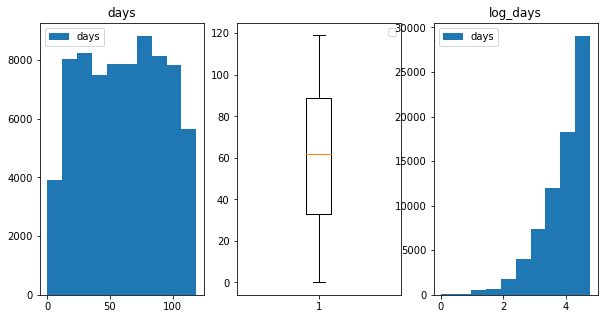

In [52]:
num_describer(df[df['Train'] == 1], 'days')

### 3.1 Генерация нового признака из празника work_address,home_address

In [53]:
df['address_agreement'] = np.where(df.work_address == df.home_address, 1, 0)
df.address_agreement.value_counts()

0    95028
1    15120
Name: address_agreement, dtype: int64

доля пропусков:  0.0
Значения параметра и их количество
0    63562
1    10237
Name: address_agreement, dtype: int64


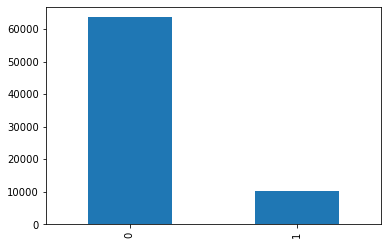

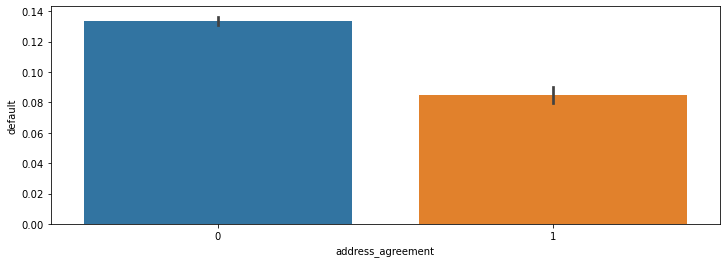

In [54]:
obj_describer(df[df['Train'] == 1], 'address_agreement')

в work_address,home_address совпадает список категорий. возможно подразумевалось что 1-центр города, 2 - пригород, 3 - область. соответственно тут можно измерить удаленность дома от работы.добавим признак


In [55]:
df['address_dist'] = df['work_address'] - df['home_address']
df['address_dist'] = df.address_dist.apply(lambda x: abs(x))
df.address_dist.value_counts()

1    87204
0    15120
2     7824
Name: address_dist, dtype: int64

доля пропусков:  0.0
Значения параметра и их количество
1    58378
0    10237
2     5184
Name: address_dist, dtype: int64


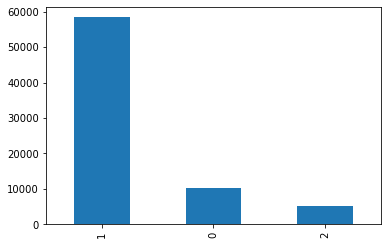

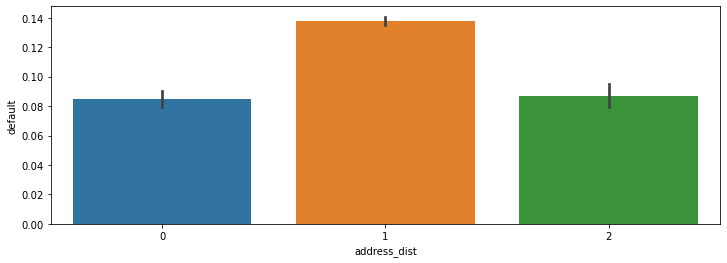

In [56]:
obj_describer(df[df['Train'] == 1], 'address_dist')

In [57]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'Train', 'month',
       'weekday', 'days', 'address_agreement', 'address_dist'],
      dtype='object')

In [58]:
#'client_id' - еще понадобится для тестовых данных
#'app_date' - просто не включу в данные
#'default' ...
#'Train' ...
#'address_agreement' проверил локально - мешается
#,'weekday'
#'address_dist'
#'days'
bin_cols = ['sex','car','car_type','good_work','foreign_passport']
cat_cols = ['education','region_rating', 'home_address', 'work_address','sna',
           'first_time','month']
num_cols = ['age','decline_app_cnt','score_bki', 'bki_request_cnt','income']

## Формируем данные для модели

In [59]:
train = df.query('Train == 1')
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,default,Train,month,weekday,days,address_agreement,address_dist
0,25905,2014-02-01,1,M,62,Y,Y,0,0,-2.008753,...,4,1,N,0.0,1,2,5,31,0,1
1,63161,2014-03-12,1,F,59,N,N,0,0,-1.532276,...,4,1,N,0.0,1,3,2,70,0,1
2,25887,2014-02-01,1,M,25,Y,N,2,0,-1.408142,...,1,4,Y,0.0,1,2,5,31,0,1
3,16222,2014-01-23,1,F,53,N,N,0,0,-2.057471,...,1,3,N,0.0,1,1,3,22,0,1
4,101655,2014-04-18,2,M,48,N,N,0,1,-1.244723,...,1,4,Y,0.0,1,4,4,107,0,1


In [60]:
test = df.query('Train == 0')
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,default,Train,month,weekday,days,address_agreement,address_dist
73799,74835,2014-03-22,2,M,29,Y,Y,0,0,-2.271884,...,1,4,N,NaN,0,3,5,80,0,1
73800,17527,2014-01-24,1,F,39,N,N,5,0,-1.504999,...,4,3,N,NaN,0,1,4,23,0,1
73801,75683,2014-03-23,3,M,50,Y,Y,0,0,-1.691339,...,1,3,Y,NaN,0,3,6,81,0,1
73802,26883,2014-02-03,1,M,56,N,N,0,0,-2.374182,...,1,3,N,NaN,0,2,0,33,0,1
73803,28862,2014-02-04,2,F,38,N,N,0,0,-2.487502,...,1,3,N,NaN,0,2,1,34,0,1


In [61]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])
    
# убедимся в преобразовании    
train.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,default,Train,month,weekday,days,address_agreement,address_dist
0,25905,2014-02-01,1,1,62,1,1,0,0,-2.008753,...,4,1,0,0.0,1,2,5,31,0,1
1,63161,2014-03-12,1,0,59,0,0,0,0,-1.532276,...,4,1,0,0.0,1,3,2,70,0,1
2,25887,2014-02-01,1,1,25,1,0,2,0,-1.408142,...,1,4,1,0.0,1,2,5,31,0,1
3,16222,2014-01-23,1,0,53,0,0,0,0,-2.057471,...,1,3,0,0.0,1,1,3,22,0,1
4,101655,2014-04-18,2,1,48,0,0,0,1,-1.244723,...,1,4,1,0.0,1,4,4,107,0,1


In [62]:
x_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
x_cat_test = OneHotEncoder(sparse=False).fit_transform(test[cat_cols].values)

print(x_cat.shape)
print(x_cat_test.shape)

(73799, 30)
(36349, 30)


<AxesSubplot:>

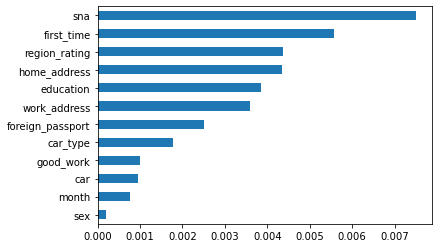

In [63]:
imp_cat = pd.Series(mutual_info_classif(train[bin_cols + cat_cols],
                                        train['default'], discrete_features=True),
                    index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [64]:
x_num = StandardScaler().fit_transform(train[num_cols])
x_num_test = StandardScaler().fit_transform(test[num_cols])
print(x_num)
print(x_num_test)

[[ 1.97211528e+00 -3.42857656e-01 -2.08798701e-01 -4.44188844e-01
  -5.00363267e-01]
 [ 1.71170539e+00 -3.42857656e-01  7.47544609e-01  4.43888001e-01
  -4.78702309e-01]
 [-1.23960668e+00  2.14387966e+00  9.96695659e-01 -4.44188844e-01
  -2.40431770e-01]
 ...
 [-7.18786904e-01 -3.42857656e-01  7.86967388e-01  8.87926424e-01
   8.44826013e-02]
 [-8.92393496e-01 -3.42857656e-01  8.53806107e-01  4.43888001e-01
  -6.08668058e-01]
 [-4.58377015e-01 -3.42857656e-01  2.81020871e-01 -1.50421558e-04
  -3.48736561e-01]]
[[-0.88473151 -0.33995109 -0.73288746  0.42909592  0.20922178]
 [-0.01615572  6.00146439  0.79551047 -0.00630055 -0.81813846]
 [ 0.93927766 -0.33995109  0.42413578 -0.44169701 -0.24738277]
 ...
 [-0.71101635  2.1966151   1.92005304 -0.44169701  0.43752406]
 [-1.05844667  0.92833201  1.31888606 -0.00630055 -0.24738277]
 [-0.10301329 -0.33995109  0.79042787 -0.00630055 -0.58983618]]


<AxesSubplot:>

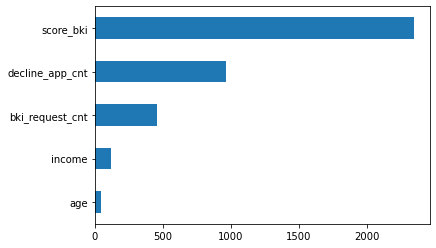

In [65]:
imp_num = Series(f_classif(train[num_cols], train['default'])[
                 0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [66]:
X = np.hstack([x_num, train[bin_cols].values, x_cat])
Y = train['default'].values
id_test = test.client_id
test = np.hstack([x_num_test, test[bin_cols].values, x_cat_test])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [68]:
import warnings

warnings.filterwarnings('ignore')

In [69]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)


# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
GSCV = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = GSCV.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


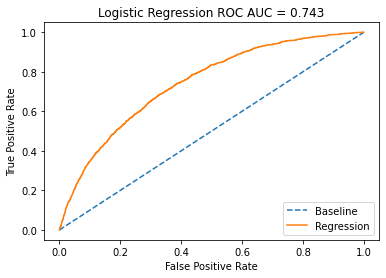

Accuracy: 0.8743
Precision: 0.3645
Recall: 0.0213
F1: 0.0403


In [70]:
model_reg = LogisticRegression(penalty='l2', C=2.78)
model_reg.fit(X_train, y_train)
probs = model_reg.predict_proba(X_test)
probs = probs[:, 1]
y_pred = model_reg.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

Нормальный показатель ROC AUC , но F-мера совсем плохая. Осуществим более точную настройку

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: 42
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False


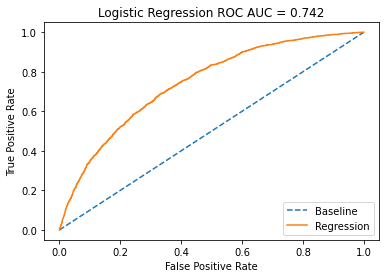

Accuracy: 0.6730
Precision: 0.2272
Recall: 0.6836
F1: 0.3411


In [71]:
model_good_reg = LogisticRegression(random_state=42)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
GS_good = GridSearchCV(model_good_reg, param_grid,
                       scoring='f1', n_jobs=-1, cv=5)
GS_good.fit(X_train, y_train)
model = GS_good.best_estimator_
# печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
# печатаем метрики
preds = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()


print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

F-мера выросла достаточно сильно, Recal и Precision тоже выросли.
Изменение Accuracy на 0.2 считаю не существенным

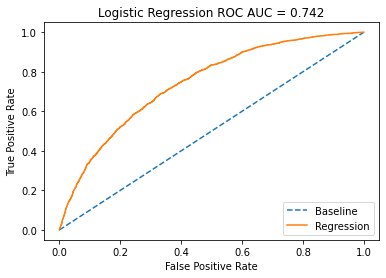

Accuracy: 0.6730
Precision: 0.2272
Recall: 0.6836
F1: 0.3411


In [72]:
final_model = LogisticRegression(penalty='l1',
                                 C=1,
                                 class_weight='balanced',
                                 dual=False,
                                 fit_intercept=True,
                                 intercept_scaling=1,
                                 l1_ratio=None,
                                 multi_class='auto',
                                 n_jobs=None,
                                 solver='liblinear',
                                 verbose=0,
                                 tol=0.001,
                                 warm_start=False)

final_model.fit(X_train, y_train)
probs = final_model.predict_proba(X_test)
probs = probs[:, 1]
preds = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

In [73]:
result_probs = final_model.predict_proba(test)[:, 1]

In [75]:
my_submission = pd.DataFrame({'client_id': id_test,
                              'default': result_probs})
my_submission.to_csv('./submission.csv', index=False)

my_submission

,client_id,default
73799,74835,0.214905
73800,17527,0.795631
73801,75683,0.321470
73802,26883,0.394718
73803,28862,0.152312
...,...,...
110143,83775,0.770687
110144,106254,0.106472
110145,81852,0.788606
110146,1971,0.565926


In [ ]:
#kaggle competitions submit -c sf-dst-scoring -f submission.csv -m "Message"